In [1]:
#!source /usr/local/Ascend/ascend-toolkit/set_env.sh
import torch

import torch.nn as nn
import math
from functools import partial
from esm.modules import ContactPredictionHead, ESM1bLayerNorm, RobertaLMHead, TransformerLayer, MultiheadAttention 
import esm
from typing import Union

In [2]:

# print(f"Number of NPU devices: {torch.npu.device_count()}")
# print(f"Current NPU device index: {torch.npu.current_device()}")
# print(f"NPU device name: {torch.npu.get_device_name(torch.npu.current_device())}")

In [3]:
class GroundingAttention(nn.Module):
    def __init__(self, dim, num_heads=4, qkv_bias=True,
                 attn_drop=0., proj_drop=0.):
        super().__init__()
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = head_dim**-0.5

        self.kv = nn.Linear(dim, dim*2, bias=qkv_bias)
        self.q = nn.Linear(dim, dim, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        # self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)

    def forward(self, x, r):
        B, N, C = x.shape
        B_, N_, C_ = r.shape

        kv = self.kv(r).reshape(B_, N_, 2, self.num_heads, C_ //
                                self.num_heads).permute(2, 0, 3, 1, 4)
        k, v = kv.unbind(0)
        q = self.q(x).reshape(B, N, self.num_heads, C //
                              self.num_heads).permute(0, 2, 1, 3)

        attn = (q @ k.transpose(-2, -1)) * self.scale  # (B, heads, N, N_)
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)

        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        # x = self.proj(x)
        x = self.proj_drop(x)
        return x

In [4]:
class FFN(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(FFN, self).__init__()
        self.relu = nn.ReLU()
        self.linear1 = nn.Linear(input_dim, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, input_dim)

    def forward(self, x):
        """
        输入 x 的形状: (batch_size, seq_len, input_dim)
        输出 y 的形状: (batch_size, seq_len, output_dim)
        """
        residual = x
        # x = x.view(-1, x.size(-1))  # 将 x 展平成二维
        x = self.linear1(x)
        x = self.relu(x)
        x = self.linear2(x)
        # x = x.view(batch_size, seq_len, -1)  # 将 x 恢复成三维
        x = residual + x
        return x

In [5]:
class bertlayer(nn.Module):
    def __init__(self, embeddingdim, hidden_dim, num_head = 16):
        super(bertlayer, self).__init__()
        self.atte_norm = ESM1bLayerNorm(embeddingdim)
        self.ffn_norm = ESM1bLayerNorm(embeddingdim)
        self.atte = torch.nn.MultiheadAttention(embed_dim = embeddingdim, num_heads = num_head, dropout = 0.0)
        self.ffn = FFN(embeddingdim, hidden_dim)
    def forward(self, x, x_padding_mask):
        residual = x
        x = self.atte_norm(x)
        x, _ = self.atte(x, x, x, key_padding_mask = x_padding_mask)
        x = x + residual
        x = x + self.ffn(self.ffn_norm(x))
        return x



In [6]:
# class InteractionBlock(nn.Module):
#     def __init__(self, embed_dim, ffn_dim, BertLayerNorm = ESM1bLayerNorm, attention_heads = 20, add_bias_kv = True, use_rotary_embeddings = True):
#         super(InteractionBlock, self).__init__()
#         # self.injector_query_norm = norm_layer(embedding_dim)
#         # self.injector_kv_norm = norm_layer(embedding_dim)
#         # self.extractor_query_norm = norm_layer(embedding_dim)
#         # self.extractor_kv_norm = norm_layer(embedding_dim)
#         # self.extractor_norm = norm_layer(embedding_dim)
#         # self.injector = GroundingAttention(embedding_dim)
#         # self.block = GroundingAttention(embedding_dim)
#         # self.extractor = GroundingAttention(embedding_dim)
#         # self.extractor_ffn = FFN(embedding_dim * ffn_dim, ffn_dim_rate * embedding_dim * ffn_dim)
#         self.attention_heads = attention_heads
#         self.embed_dim = embed_dim
#         self.ffn_dim = ffn_dim
#         self.injector_q_norm = BertLayerNorm(embed_dim)
#         self.injector_kv_norm = BertLayerNorm(embed_dim)
#         self.injector = GroundingAttention(embed_dim)
#         self.block = TransformerLayer(
#             self.embed_dim,
#             4 * self.embed_dim, # embed_dim = 1280
#             self.attention_heads, # 20
#             add_bias_kv=False,
#             use_esm1b_layer_norm=True,
#             use_rotary_embeddings=True,
#         )
#         self.extractor_q_norm = BertLayerNorm(embed_dim)
#         self.extractor_kv_norm = BertLayerNorm(embed_dim)
#         self.extractor = GroundingAttention(embed_dim)
#         self.ffn = FFN(embed_dim, ffn_dim)
#     def forward(self, x, r, self_attn_mask=None, self_attn_padding_mask=None, need_head_weights=False):
#         # x = self.injector(self.injector_query_norm(x), self.injector_kv_norm(r)) + x
#         # x = self.block(x, x)
#         # r = self.extractor(self.extractor_query_norm(r), self.extractor_kv_norm(x)) + r
#         # r = r + self.extractor_ffn(self.extractor_norm(r))
#         
#         
#         # x, _ = self.injector_attention(
#         #     query=self.injector_q_norm(x),
#         #     key=self.injector_kv_norm(r),
#         #     value=self.injector_kv_norm(r),
#         #     key_padding_mask=self_attn_padding_mask,
#         #     need_weights=True,
#         #     need_head_weights=need_head_weights,
#         #     attn_mask=self_attn_mask,
#         # )
#         # print(self.injector_q_norm(x).shape)
#         # print(self.injector_q_norm(r).shape)
#         x = x + self.injector(self.injector_q_norm(x),self.injector_kv_norm(r))
#         x, _ = self.block(x,
#                           self_attn_padding_mask=self_attn_padding_mask,
#                           need_head_weights=need_head_weights,
#                           )
#         r = r + self.extractor(self.extractor_q_norm(r),self.extractor_kv_norm(x))
#         r = self.ffn(r)
#         return x, r
class InteractionBlock(nn.Module):
    def __init__(self, embed_dim, ffn_dim, BertLayerNorm = ESM1bLayerNorm, attention_heads = 16, add_bias_kv = True, use_rotary_embeddings = True):
        super(InteractionBlock, self).__init__()
        # self.injector_query_norm = norm_layer(embedding_dim)
        # self.injector_kv_norm = norm_layer(embedding_dim)
        # self.extractor_query_norm = norm_layer(embedding_dim)
        # self.extractor_kv_norm = norm_layer(embedding_dim)
        # self.extractor_norm = norm_layer(embedding_dim)
        # self.injector = GroundingAttention(embedding_dim)
        # self.block = GroundingAttention(embedding_dim)
        # self.extractor = GroundingAttention(embedding_dim)
        # self.extractor_ffn = FFN(embedding_dim * ffn_dim, ffn_dim_rate * embedding_dim * ffn_dim)
        self.attention_heads = attention_heads
        self.embed_dim = embed_dim
        self.ffn_dim = ffn_dim
        self.injector_q_norm = BertLayerNorm(embed_dim)
        self.injector_kv_norm = BertLayerNorm(embed_dim)
        # self.injector = GroundingAttention(embed_dim)

        self.injector = torch.nn.MultiheadAttention(embed_dim = embed_dim, num_heads = attention_heads, dropout = 0.0)
        self.block = bertlayer(embed_dim, embed_dim * 4)
        self.extractor_q_norm = BertLayerNorm(embed_dim)
        self.extractor_kv_norm = BertLayerNorm(embed_dim)
        self.extractor = torch.nn.MultiheadAttention(embed_dim = embed_dim, num_heads = attention_heads, dropout = 0.0)
        self.ffn = FFN(embed_dim, ffn_dim)
    def forward(self, x, r, x_attn_padding_mask=None, r_attn_padding_mask = None, need_head_weights=False):
        # x = self.injector(self.injector_query_norm(x), self.injector_kv_norm(r)) + x
        # x = self.block(x, x)
        # r = self.extractor(self.extractor_query_norm(r), self.extractor_kv_norm(x)) + r
        # r = r + self.extractor_ffn(self.extractor_norm(r))
        
        
        # x, _ = self.injector_attention(
        #     query=self.injector_q_norm(x),
        #     key=self.injector_kv_norm(r),
        #     value=self.injector_kv_norm(r),
        #     key_padding_mask=self_attn_padding_mask,
        #     need_weights=True,
        #     need_head_weights=need_head_weights,
        #     attn_mask=self_attn_mask,
        # )
        # print(self.injector_q_norm(x).shape)
        # print(self.injector_q_norm(r).shape)
        
        
        # x = x + self.injector(self.injector_q_norm(x),self.injector_kv_norm(r))
        residual_x = x
        residual_r = r
        # x = self.injector_q_norm(x)
        # r = self.injector_kv_norm(r)
        x = x.transpose(0, 1)
        r = r.transpose(0, 1)
        x = self.injector_q_norm(x)
        r = self.injector_kv_norm(r)
        # print("r.shape")
        # print(r.shape)
        # print("r_attn_padding_mask.shape")
        # print(r_attn_padding_mask.shape)
        # print("x.shape")
        # print(x.shape)
        x, attn = self.injector(x, r, r, key_padding_mask=r_attn_padding_mask )
        x = x.transpose(0, 1)
        x = x + residual_x
        r = residual_r
        x = x.transpose(0, 1)
        # print(x_attn_padding_mask.shape, x.shape)
        x = self.block(x, x_attn_padding_mask)
        
        # r = r + self.extractor(self.extractor_q_norm(r),self.extractor_kv_norm(x))
        residual_r = r
        residual_x = x.transpose(0, 1)
        # x = self.extractor_kv_norm(x)
        # r = self.extractor_q_norm(r)
        # x = x.transpose(0, 1)
        r = r.transpose(0, 1)
        # print(r.shape)
        # print(x.shape)
        # print(x_attn_padding_mask.shape)
        x = self.extractor_kv_norm(x)
        r = self.extractor_q_norm(r)
        r, attn = self.extractor(r, x, x, key_padding_mask=x_attn_padding_mask)
        r = r.transpose(0, 1)
        r = r + residual_r
        
        r = self.ffn(r)
        return residual_x, r

In [7]:
# class part_test(nn.Module):
#     def __init__(self, embedding_dim, ffn_dim, device, num_layers =36):
#         super(part_test, self).__init__()
#         self.layers = nn.ModuleList()
#         for _ in range(num_layers):
#             block = MultiheadAttention(
#                     embedding_dim,
#                     20,
#                     add_bias_kv=False,
#                     add_zero_attn=False,
#                     use_rotary_embeddings=False,
#                     encoder_decoder_attention=True
#                 )
#             self.layers.append(block)
#     def forward(self, x, x_attn_padding_mask):
#         for layer in self.layers:
#             x, attn = layer(
#                 query=x,
#                 key=x,
#                 value=x,
#                 key_padding_mask=x_attn_padding_mask, #【[fffffttttt]】之类的
#                 need_weights=False,
#                 need_head_weights=False,# false
#                 attn_mask=None, # None
#             )
#         return x
# device = torch.device('npu:0')
# modelb = part_test(1280, 1280  * 4,device)
# X = torch.randn(30,15,1280)
# x_attn_padding_mask = torch.zeros(15,30, dtype=torch.bool)
# X = X.to(device)
# x_attn_padding_mask = x_attn_padding_mask.to(device)
# modelb.to(device)
# opt = torch.optim.Adam(modelb.parameters(), lr=0.00001)
# nuuu = 500000
# for i in range(nuuu):
#     x= modelb(X, x_attn_padding_mask)
#     y = x.sum()
#     y.backward()
#     opt.step()
#     # print(y)
#     if i ==2:
#         print("start")
#     if i ==nuuu - 1:
#         print("done")

In [8]:
# embedding_dim = 1280
# modelb = TransformerLayer(
#                 embedding_dim,
#                 embedding_dim *4, # embed_dim = 1280
#                 20, # 20
#                 add_bias_kv=False,
#                 use_esm1b_layer_norm=True,
#                 use_rotary_embeddings=False,
#             )
# X = torch.randn(50,15,embedding_dim)
# x_attn_padding_mask = torch.zeros(15,50, dtype=torch.bool)
# X = X.to(device)
# x_attn_padding_mask = x_attn_padding_mask.to(device)
# modelb.to(device)
# opt = torch_npu.optim.NpuFusedAdamW(modelb.parameters(), lr=1e-3, betas=(0.9, 0.999), eps=1e-8, weight_decay=1e-2, amsgrad=False)
# nuuu = 5000
# for i in range(nuuu):
#     x, _ = modelb(X,
#         self_attn_padding_mask=x_attn_padding_mask,
#         need_head_weights=False,
#     )
#     y = x.sum()
#     y.backward()
#     opt.step()
#     # print(y)
#     if i ==2:
#         print("start")
#     if i ==nuuu - 1:
#         print("done")

In [9]:
import esm
class DynamicFeatureSelector(nn.Module):
    def __init__(self, input_size, num_features, num_layers=4):
        super(DynamicFeatureSelector, self).__init__()
        
        # 自动计算每层的节点数量
        self.hidden_layers = []
        self.batch_norm_layers = []  # 用于存储 BatchNorm 层
        current_size = input_size
        decrement = (input_size - num_features) // num_layers  # 递减的步长

        # 添加隐藏层和 BatchNorm 层
        for _ in range(num_layers):
            if current_size <= num_features:
                break
            next_size = max(current_size - decrement, num_features)
            self.hidden_layers.append(nn.Linear(current_size, next_size))
            self.batch_norm_layers.append(nn.BatchNorm1d(next_size))  # 添加 BatchNorm 层
            current_size = next_size

        # 将隐藏层和 BatchNorm 层转换为 ModuleList
        self.hidden_layers = nn.ModuleList(self.hidden_layers)
        self.batch_norm_layers = nn.ModuleList(self.batch_norm_layers)
        self.output_layer = nn.Linear(current_size, num_features)  # 输出层

    def forward(self, x):
        for layer, batch_norm in zip(self.hidden_layers, self.batch_norm_layers):
            x = layer(x)  # 前向传播
            x = batch_norm(x)  # 归一化
            x = torch.relu(x)  # 激活函数
        x = self.output_layer(x)
        return x

class mpi_adapter(nn.Module):
    def __init__(self, embedding_dim, ffn_dim, device, num_layers =39):
        super(mpi_adapter, self).__init__()
        # self.embedding = nn.Embedding(num_embeddings=22, embedding_dim=embedding_dim)
        # self.par_position = PositionalEncoding(num_hiddens=embedding_dim, max_len = par_len)
        # self.mut_position = PositionalEncoding(num_hiddens=embedding_dim, max_len = mut_len)
        # self.mut_esm, _ = esm.pretrained.esm2_t33_650M_UR50D()
        # _, self.alphabet = esm.pretrained.esm2_t33_650M_UR50D()
        # self.padding_idx = self.alphabet.padding_idx
        self.device = device
        # self.esm.to(self.device)
        # self.esm.eval()
        # self.liner_mut = nn.Linear(1280,embedding_dim)
        # self.liner_par = nn.Linear(1280,embedding_dim)
        # self.batch_converter = self.alphabet.get_batch_converter()
        self.layers = nn.ModuleList()
        for _ in range(num_layers):
            self.layers.append(InteractionBlock(embedding_dim, ffn_dim))
    def forward(self, mut0, mut1, par, mut0_padding_mask, par_padding_mask):
        # print([(str(0), sequence) for sequence in mut0s])
        # print([(str(0), sequence) for sequence in mut1s])
        # print([(str(0), sequence) for sequence in pars])
        # _, _, mut0 = self.batch_converter([(str(0), sequence) for sequence in mut0s])
        # _, _, mut1 = self.batch_converter([(str(0), sequence) for sequence in mut1s])
        # _, _, par = self.batch_converter([(str(0), sequence) for sequence in pars])
        # print(par)
        # mut0 = mut0s.to(self.device)
        # mut1 = mut1s.to(self.device)
        # par = pars.to(self.device)
        # mut0_padding_mask = mut0_padding_mask.to(self.device)
        # par_padding_mask = par_padding_mask.to(self.device)
        # mut0_padding_mask = mut0.eq(self.padding_idx)
        # mut1_padding_mask = mut1.eq(self.padding_idx)
        # par_padding_mask = par.eq(self.padding_idx)
        # mut0_padding_mask = torch.cat((mut0_padding_mask,mut1_padding_mask),dim=1)
        mut0 = torch.cat((mut0,mut1),dim=1)
        # mut0 = self.liner_mut(mut0)
        # par = self.liner_par(par)
        for layer in self.layers:
            mut0, par = layer(mut0, par, x_attn_padding_mask = mut0_padding_mask, r_attn_padding_mask = par_padding_mask)
        return par
    
# device = torch.device('npu:0')
# # modelb =  TransformerLayer(
# #             1280,
# #             4000, # embed_dim = 1280
# #             20, # 20
# #             add_bias_kv=False,
# #             use_esm1b_layer_norm=True,
# #             use_rotary_embeddings=False,
# #         )
# modelb = mpi_adapter(1280*3, 1280 * 3 * 4,device)
# X = torch.randn(10,15,1280)
# X2 = torch.randn(10,15,1280)
# R = torch.randn(10,100,1280)
# x_attn_padding_mask = torch.zeros(10,30, dtype=torch.bool)
# R_attn_padding_mask = torch.zeros(10,100, dtype=torch.bool)
# X = X.to(device)
# X2 = X2.to(device)
# R = R.to(device)
# x_attn_padding_mask = x_attn_padding_mask.to(device)
# R_attn_padding_mask = R_attn_padding_mask.to(device)
# modelb.to(device)
# opt = torch.optim.Adam(modelb.parameters(), lr=0.00001)
# nuuu = 500000
# for i in range(nuuu):
#     x= modelb(X, X2, R, x_attn_padding_mask, R_attn_padding_mask)
#     y = x.sum()
#     y.backward()
#     opt.step()
#     # print(y)
#     if i ==2:
#         print("start")
#     if i ==nuuu - 1:
#         print("done")


In [10]:
# for layer in modelb.layers:
#     print(next(layer.parameters()).device)

In [11]:
# embedding_dim = 1280*4
# batch_size = 400
# modelb = InteractionBlock(embedding_dim, embedding_dim * 4)
# X = torch.randn(batch_size ,30,embedding_dim)
# # X2 = torch.randn(batch_size ,15,embedding_dim)
# R = torch.randn(batch_size ,100,embedding_dim)
# x_attn_padding_mask = torch.zeros(batch_size ,30, dtype=torch.bool)
# R_attn_padding_mask = torch.zeros(batch_size ,100, dtype=torch.bool)
# X = X.to(device)
# # X2 = X2.to(device)
# R = R.to(device)
# x_attn_padding_mask = x_attn_padding_mask.to(device)
# R_attn_padding_mask = R_attn_padding_mask.to(device)
# modelb.to(device)
# opt = torch.optim.Adam(modelb.parameters(), lr=0.00001)
# nuuu = 500000
# for i in range(nuuu):
#     x , _= modelb(X, R, x_attn_padding_mask, R_attn_padding_mask)
#     y = x.sum()
#     y.backward()
#     opt.step()
#     if i ==2:
#         print("start")
#     if i ==nuuu - 1:
#         print("done")

In [12]:
class MLP_head(nn.Module):
    def __init__(self, embedding_dim, num_layers = 2):
        super(MLP_head, self).__init__()
        self.layers = nn.ModuleList()
        for _ in range(num_layers):
            self.layers.append(GroundingAttention(embedding_dim))
    def forward(self, x):
        for layer in self.layers:
            x = layer(x, x)
        return x[:, 0, :]

In [13]:
class MLP_head_one_layer(nn.Module):
    def __init__(self, embedding_dim, device, num_layers = 1,attention_heads = 16):
        super(MLP_head_one_layer, self).__init__()
        self.layers = nn.ModuleList()
        self.device = device
        self.attention = torch.nn.MultiheadAttention(embed_dim = embedding_dim, num_heads = attention_heads, dropout = 0.0)
        # for _ in range(num_layers):
        #     self.layers.append(TransformerLayer(
        #         embedding_dim,
        #         4 * embedding_dim, # embed_dim = 1280
        #         attention_heads, # 20
        #         add_bias_kv=False,
        #         use_esm1b_layer_norm=True,
        #         use_rotary_embeddings=True,
        #         ))
    def forward(self, x, x_attn_padding_mask, need_head_weights=False):
        x_attn_padding_mask = x_attn_padding_mask.to(self.device)
        result = x[:, 0:1, :]
        x = x.transpose(0, 1)
        result = result.transpose(0, 1)
        result, attn = self.attention(result, x, x, key_padding_mask = x_attn_padding_mask)
        # for layer in self.layers:
        #     x = x.transpose(0, 1)
        #     x, _ = layer(x,
        #                 self_attn_padding_mask=x_attn_padding_mask,
        #                 need_head_weights=need_head_weights,
        #                 )
        #     x = x.transpose(0, 1)
        result = result.transpose(0, 1)
        result = result.squeeze(1)
        return result

In [14]:
#bert中的带权交叉熵顺势函数
class cross_entropy_bert(nn.Module):
    def __init__(self, device):
        super(cross_entropy_bert, self).__init__()
        # self.liner = nn.Linear(embedding_dim, 4)
        self.activate = nn.Sigmoid()
        self.device = device
    def forward(self, b_labels, outputs, weights):
        # weights = weights
        # outputs = self.liner(outputs)
        # print("output:")
        # print(outputs)
        # outputs = self.activate(outputs)
        labels = []
        for index, fue in enumerate(b_labels):
            labels.append(fue)
        loss_sum = torch.tensor(0)
        for i in range(outputs.shape[0]):
            back_part = torch.tensor(0).to(device)
            for j in outputs[i]:
                back_part = back_part + torch.exp(j).to(device)
            back_part = torch.log(back_part).to(device)
            loss_sum = weights[labels[i]] * ((-1) * outputs[i][labels[i]] + back_part)
        loss_sum = loss_sum/outputs.shape[0]
        return loss_sum


In [15]:
import torch
import torch.nn as nn
import numpy as np

class GraphEmbeddingLayer(nn.Module):
    def __init__(self, embed_dim=1280, max_len=1500):
        super(GraphEmbeddingLayer, self).__init__()
        
        self.embed_dim = embed_dim
        self.max_len = max_len
        
        # 嵌入层
        self.embedding = nn.Embedding(num_embeddings=max_len, embedding_dim=embed_dim)
        
        # 位置编码
        self.position_encoding = self._generate_positional_encoding(max_len, embed_dim)

    def _generate_positional_encoding(self, max_len, embed_dim):
        position = np.arange(max_len)[:, np.newaxis]  # (max_len, 1)
        div_term = np.exp(np.arange(0, embed_dim, 2) * -(np.log(10000.0) / embed_dim))  # (embed_dim/2,)
        pos_enc = np.zeros((max_len, embed_dim))
        pos_enc[:, 0::2] = np.sin(position * div_term)  # 偶数维度
        pos_enc[:, 1::2] = np.cos(position * div_term)  # 奇数维度
        return torch.FloatTensor(pos_enc)

    def forward(self, x):
        # x 应该是一个形状为 (batch_size, seq_length) 的张量
        batch_size, seq_length = x.size()
        
        # 嵌入
        embedded = self.embedding(x)  # (batch_size, seq_length, embed_dim)

        # 添加位置编码
        pos_enc = self.position_encoding[:seq_length, :].unsqueeze(0)  # (1, seq_length, embed_dim)
        output = embedded + pos_enc.to(embedded.device)

        return output

In [16]:
def positional_encoding(max_len, d_model):
    # 创建位置编码矩阵
    position = torch.arange(max_len, dtype=torch.float).unsqueeze(1)  # 形状为 (max_len, 1)
    div_term = torch.exp(torch.arange(0, d_model, 2).float() * -(np.log(10000.0) / d_model))  # 计算分母
    
    # 计算位置编码
    pe = torch.zeros(max_len, d_model)  # 初始化位置编码矩阵
    pe[:, 0::2] = torch.sin(position * div_term)  # 偶数维度
    pe[:, 1::2] = torch.cos(position * div_term)  # 奇数维度
    pe.requires_grad = False
    return pe

In [64]:
class Sum_model(nn.Module):
    def __init__(self, device, embedding_dim = 128,):
        super(Sum_model, self).__init__()
        self.device = device
        self.embedding = nn.Embedding(23, 44)
        self.result = nn.Parameter(torch.randn(embedding_dim))
        self.backbone = mpi_adapter(embedding_dim, embedding_dim*4,device)
        self.neck = MLP_head_one_layer(embedding_dim, device)
        # self.head = cross_entropy_bert(embedding_dim, device)
        self.head = nn.Linear(embedding_dim, 4)
    def forward(self,  mut0s, mut1s, pars, mut0_padding_mask, par_padding_mask, pssm_mut0, pssm_mut1, pssm_par, weight, label):
        positions_mut = positional_encoding(42, 64).repeat(mut0s.shape[0], 1, 1).to(self.result.device)
        positions_par = positional_encoding(pars.shape[1], 64).repeat(mut0s.shape[0], 1, 1).to(self.result.device)
        mut0s = self.embedding(mut0s)
        mut1s = self.embedding(mut1s)
        pars = self.embedding(pars)
        res = self.result.repeat(pars.shape[0], 1).unsqueeze(1)
        mut0s = torch.cat((mut0s, pssm_mut0), dim = 2)
        mut1s = torch.cat((mut1s, pssm_mut1), dim = 2)
        pars = torch.cat((pars, pssm_par), dim = 2)
        mut0s = torch.cat((mut0s, positions_mut[ : , : mut0s.shape[1], : ]), dim = 2)
        mut1s = torch.cat((mut1s, positions_mut[ : , 21 : 21 + mut0s.shape[1], : ]), dim = 2)
        pars = torch.cat((pars, positions_par), dim = 2)
        pars = torch.concat([res,pars], dim = 1)
        false_column = torch.zeros(par_padding_mask.size(0), 1, dtype=torch.bool).to(self.device)
        # 在第一列前添加一排 False
        par_padding_mask = torch.cat((false_column, par_padding_mask), dim=1)
        # print(mut0s.dtype)
        x = self.backbone(mut0s.float(), mut1s.float(), pars.float(), mut0_padding_mask, par_padding_mask)
        # print("x1:")
        # x = self.neck(pars, par_padding_mask)
        x = self.neck(x, par_padding_mask)
        # print("x2")
        # print(x)
        # x = self.head(label, x, weight)
        x = self.head(x)
        return x

In [71]:
# model = Sum_model(device)
# model.to(device)
# mut0 = batch_converter(batch["mut0_51"].tolist())[:, 25 - len_half_protein_used: 25 + len_half_protein_used]
# mut1 = batch_converter(batch["mut1_51"].tolist())[:, 25 - len_half_protein_used: 25 + len_half_protein_used]
# par0 = batch_converter(batch["par0"].tolist())
# mut0_mask = mut0.eq(1).to(device)
# mut1_mask = mut1.eq(1).to(device)
# par0_mask = par0.eq(0).to(device)
# mut0 = mut0.to(device)
# mut1 = mut1.to(device)
# par0 = par0.to(device)

# out = model(mut0.long(), mut1.long(), par0, torch.cat((mut0_mask, mut1_mask),dim = 1), par0_mask, torch.tensor(batch['pssm_win_mut0'].tolist())[:, 25 - len_half_protein_used: 25 + len_half_protein_used, :].to(device), torch.tensor(batch['pssm_win_mut1'].tolist())[:, 25 - len_half_protein_used: 25 + len_half_protein_used, :].to(device), torch.tensor(batch['pssm_par0'].tolist())[ : , : par0.shape[1]].to(device), class_weights, batch["label"])
# loss = model_loss(batch["label"], out,class_weights)
# _, predicted_labels = torch.max(out, 1)

In [44]:
batch_converter(['VLSYTQAQKEAIYRQLDQTTQRFNVGLVAITDVQNARAQYDTVLANEVTAR']), batch["mut0_51"].tolist()

(tensor([[19, 11, 17, 21, 18, 15,  2, 15, 10,  5,  2,  9, 21, 16, 15, 11,  4, 15,
          18, 18, 15, 16,  6, 13, 19,  7, 11, 19,  2,  9, 18,  4, 19, 15, 13,  2,
          16,  2, 15, 21,  4, 18, 19, 11,  2, 13,  5, 19, 18,  2, 16]]),
 ['VLSYTQAQKEAIYRQLDQTTQRFNVGLVAITDVQNARAQYDTVLANEVTAR',
  'HFVALNGSKLNINLKMGVEWTSCAEVVSQEKTMFPNLTDVREVVTDQFLCS',
  'NVHLSHPVYVRRAATENIPVVRRPDRKDLLGYLNGEASTSASIDRSAPLEI',
  'KLDDIEEFENIRKDLETRKKQKEDVEVVGGSDGEGAIGLSSDPKSREQMIN',
  'RTFAGNTPLHLAAGLGYPTLTRLLLKAGADIHAENEEPLCPLPSPPTSDSD',
  'DSMGHVGFVIKKGKIVSLVKGSSAARNGLLTNHYVCEVDGQNVIGLKDKKI',
  'TDTNSYAAWAERISDLFARHRTKMRRKKRFAKQGNKWYKQHLSYRLVNWPE'])

In [18]:
# model = Sum_model(device)
# print(f"Using device: {device}")
# model.to(device)
# _,_,mut0 = batch_converter([(str(0), sequence) for sequence in batch["mut0_51"]])[26 - len_half_protein_used : 26 + len_half_protein_used]
# _,_,mut1 = batch_converter([(str(0), sequence) for sequence in batch["mut1_51"]])[26 - len_half_protein_used : 26 + len_half_protein_used]
# _,_,par0 = batch_converter([(str(0), sequence) for sequence in batch["par0"]])
# mut0 = mut0[:, 1:-1]
# mut1 = mut1[:, 1:-1]
# mut0_mask = mut0.eq(padding_idx).to(device)
# mut1_mask = mut1.eq(padding_idx).to(device)
# par0_mask = par0.eq(padding_idx).to(device)
# mut0 = mut0.unsqueeze(2)
# mut1 = mut1.unsqueeze(2)
# mut0 = mut0.to(device)
# mut1 = mut1.to(device)
# par0 = par0.to(device)

# out = model(mut0.long(), mut1.long(), par0, None, par0_mask, torch.tensor(batch['pssm_win_mut0'])[:, 25 - len_half_protein_used: 25 + len_half_protein_used, :].to(device), torch.tensor(batch['pssm_win_mut1'])[:, 25 - len_half_protein_used: 25 + len_half_protein_used, :].to(device), torch.tensor(batch['pssm_par0'])[ : , : par0.shape[1] - 2], class_weights, batch["label"])
# loss = model_loss(batch["label"], out,class_weights)
# _, predicted_labels = torch.max(out, 1)

In [19]:
class PandasDataReader:
    def __init__(self, df, batch_size=1, shuffle=False):
        self.df = df.sample(frac=1).reset_index(drop=True) if shuffle else df
        self.batch_size = batch_size
        self.current_index = 0

    def __iter__(self):
        return self

    def __next__(self):
        if self.current_index >= len(self.df):
            raise StopIteration()

        batch = self.df.iloc[self.current_index:self.current_index+self.batch_size]
        self.current_index += self.batch_size

        # 如果 batch_size 为 1, 则直接返回 batch 的第一行
        return batch.iloc[0] if self.batch_size == 1 else batch
# data_reader = PandasDataReader(df, batch_size=7, shuffle=True)

In [20]:
class ESMModelWrapper(nn.Module):
    def __init__(self, model):
        super(ESMModelWrapper, self).__init__()
        self.model = model

    def forward(self, batch_tokens, repr_layers=[33], return_contacts=False):
        return self.model(batch_tokens, repr_layers=repr_layers, return_contacts=return_contacts)


class ESMFeatureEncoder(nn.Module):
    def __init__(self):
        super(ESMFeatureEncoder, self).__init__()
        self.device = 'cuda:3'
        self.model, self.alphabet = esm.pretrained.esm2_t33_650M_UR50D()
        self.model.to(self.device)
        self.model.eval()  # Set the model to evaluation mode
        self.batch_converter = self.alphabet.get_batch_converter()
        self.padding_idx = self.alphabet.padding_idx
        # Wrap the model with the ESMModelWrapper
        self.model = ESMModelWrapper(self.model)

    def encode(self, sequences):
        batch_labels, batch_strs, batch_tokens = self.batch_converter([(str(0), sequence) for sequence in sequences])
        batch_tokens = batch_tokens.to(self.device)
        batch_mask = batch_tokens.eq(self.padding_idx)
        # print(batch_tokens.shape)
        with torch.no_grad():
            results = self.model(batch_tokens, repr_layers=[33], return_contacts=False)
        token_representations = results['representations'][33]
        # print(results['representations'][33].mean(dim=1).unsqueeze(1).shape)
        return token_representations,batch_mask

In [21]:
import pandas as pd
data_path = 'mippi/processed_mutations.dataset'
df = pd.read_pickle(data_path)
df = df[df['mut0'] != df['mut1']]
new_df1 = df[df['label'] == 1].copy()
new_df1['mut0'], new_df1['mut1'] = new_df1['mut1'], new_df1['mut0']
new_df1['label'] = 3
new_df2 = df[df['label'] == 3].copy()
new_df2['mut0'], new_df2['mut1'] = new_df2['mut1'], new_df2['mut0']
new_df2['label'] = 1

new_df3 = df[df['label'] == 2].copy()
new_df3['mut0'], new_df3['mut1'] = new_df3['mut1'], new_df3['mut0']
new_df3['label'] = 2
df = pd.concat([df, new_df2, new_df1, new_df3], ignore_index=True)
df["position_total"] = df["Feature range(s)"].apply(
    lambda x: sorted(set([int(y.split("-")[0]) for y in x] + [int(y.split("-")[1]) for y in x]))
)
df["position"] = df["position_total"].apply(lambda x: math.ceil((min(x) + max(x)) / 2))
print(df.shape)
df.head()

(37639, 26)


,#Feature AC,Feature range(s),Original sequence,Resulting sequence,Feature short label,Feature type,Feature annotation,Affected protein AC,Affected protein symbol,Affected protein full name,...,n_partner,mutAC,mut0,parAC,par0,mut1,label,mutAC1,position_total,position
0,EBI-10039489,[81-81],[V],[E],p.Val81Glu,mutation disrupting(MI:0573),,P28795,PEX3,,...,2,P28795,MAPNQRSRSLLQRHRGKVLISLTGIAALFTTGSVVVFFVKRWLYKQ...,Q03694,MVLSRGETKKNSVRLTAKQEKKPQSTFQTLKQSLKLSNNKKLKQDS...,MAPNQRSRSLLQRHRGKVLISLTGIAALFTTGSVVVFFVKRWLYKQ...,0,P28795_Val81Glu,[81],81
1,EBI-10039495,[188-188],[N],[I],p.Asn188Ile,mutation decreasing(MI:0119),,P28795,PEX3,,...,2,P28795,MAPNQRSRSLLQRHRGKVLISLTGIAALFTTGSVVVFFVKRWLYKQ...,Q03694,MVLSRGETKKNSVRLTAKQEKKPQSTFQTLKQSLKLSNNKKLKQDS...,MAPNQRSRSLLQRHRGKVLISLTGIAALFTTGSVVVFFVKRWLYKQ...,1,P28795_Asn188Ile,[188],188
2,EBI-10039551,[81-81],[V],[E],p.Val81Glu,mutation disrupting(MI:0573),,P28795,PEX3,,...,2,P28795,MAPNQRSRSLLQRHRGKVLISLTGIAALFTTGSVVVFFVKRWLYKQ...,Q03694,MVLSRGETKKNSVRLTAKQEKKPQSTFQTLKQSLKLSNNKKLKQDS...,MAPNQRSRSLLQRHRGKVLISLTGIAALFTTGSVVVFFVKRWLYKQ...,0,P28795_Val81Glu,[81],81
3,EBI-10039706,[81-81],[V],[E],p.Val81Glu,mutation disrupting(MI:0573),,P28795,PEX3,,...,2,P28795,MAPNQRSRSLLQRHRGKVLISLTGIAALFTTGSVVVFFVKRWLYKQ...,Q03694,MVLSRGETKKNSVRLTAKQEKKPQSTFQTLKQSLKLSNNKKLKQDS...,MAPNQRSRSLLQRHRGKVLISLTGIAALFTTGSVVVFFVKRWLYKQ...,0,P28795_Val81Glu,[81],81
4,EBI-10039722,[81-81],[V],[E],p.Val81Glu,mutation disrupting(MI:0573),,P28795,PEX3,,...,2,P28795,MAPNQRSRSLLQRHRGKVLISLTGIAALFTTGSVVVFFVKRWLYKQ...,Q03694,MVLSRGETKKNSVRLTAKQEKKPQSTFQTLKQSLKLSNNKKLKQDS...,MAPNQRSRSLLQRHRGKVLISLTGIAALFTTGSVVVFFVKRWLYKQ...,0,P28795_Val81Glu,[81],81


In [22]:
len_half_protein_used =10 
# seq_lengths = df['Original sequence'].apply(lambda x: len(x[0]))
# # 选择唯一元素长度小于等于 10 的行
# df_filtered = df.loc[seq_lengths <= len_half_protein_used]
# seq_lengths = df['Resulting sequence'].apply(lambda x: len(x[0]))
# # 选择唯一元素长度小于等于 10 的行
# df_filtered = df.loc[seq_lengths <= len_half_protein_used]
df = df[df["position_total"].apply(lambda x: max(x) - min(x) < 2* len_half_protein_used)]
df.shape

(36257, 26)

In [23]:
df = df[df['mut0'].str.len() <= 1500]
df = df[df['par0'].str.len() <= 1000]
df = df[df['label'] != 4]
df.shape

(30173, 26)

In [24]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

class GHMC_Loss(nn.Module):
    def __init__(self, device, bins=8, momentum=0.3):
        super(GHMC_Loss, self).__init__()
        self.device = device
        self.bins = bins
        self.momentum = momentum
        self.edges = [float(x) / self.bins for x in range(self.bins + 1)]
        if momentum > 0:
            self.acc_sum = np.zeros(bins)

    def forward(self, targets, logits, no_meaning):
        targets = torch.tensor(targets.to_list())
        targets = F.one_hot(targets, num_classes=4).float().to(self.device)
        # Calculate gradient norm
        edges = self.edges
        mmt = self.momentum
        weights = torch.zeros_like(logits)
        g = torch.abs(logits.softmax(dim=1).detach().to(self.device) - targets.to(self.device))

        tot = logits.shape[0] * logits.shape[1]  # Total number of elements
        n = 0  # n valid bins
        for i in range(self.bins):
            inds = (g >= edges[i]) & (g < edges[i + 1])
            num_in_bin = inds.sum().item()
            if num_in_bin > 0:
                if mmt > 0:
                    self.acc_sum[i] = mmt * self.acc_sum[i] + (1 - mmt) * num_in_bin
                    weights[inds] = tot / self.acc_sum[i]
                else:
                    weights[inds] = tot / num_in_bin
                n += 1
        if n > 0:
            weights = weights / n

        # Flatten targets to match logits shape
        targets = targets.argmax(dim=1)

        # Calculate the loss
        loss = F.cross_entropy(logits, targets, reduction='none')

        # Apply weights to the loss
        weights = weights.max(dim=1)[0]  # Get the maximum weight for each sample
        loss = (loss * weights).sum() / tot

        return loss

In [25]:
# modelb = Sum_model(device)
# print(f"Using device: {device}")
# modelb.to(device)
# out = modelb(mut0.long(), mut1.long(), par0,torch.cat((mut0_mask,mut1_mask),dim=1),par0_mask, class_weights,batch["label"])

In [26]:
import pandas as pd

# 读取之前保存的 DataFrame
df_s = pd.read_pickle('/data_7/lyk/mippi/processed_mutations (1).dataset')
df_s.head()

,#Feature AC,Feature range(s),Original sequence,Resulting sequence,Feature short label,Feature type,Feature annotation,Affected protein AC,Affected protein symbol,Affected protein full name,...,parAC,par0,mut1,label,mutAC1,pssm_par0,mut0_51,mut1_51,pssm_win_mut1,pssm_win_mut0
0,EBI-10039489,[81-81],[V],[E],p.Val81Glu,mutation disrupting(MI:0573),,P28795,PEX3,,...,Q03694,MVLSRGETKKNSVRLTAKQEKKPQSTFQTLKQSLKLSNNKKLKQDS...,MAPNQRSRSLLQRHRGKVLISLTGIAALFTTGSVVVFFVKRWLYKQ...,0,P28795_Val81Glu,"[[-1.0, -2.0, -3.0, -3.0, -1.0, -1.0, -2.0, -3...",IKEQIKRRFEQTQEDSLYTIYELLPVWRMVLNENDLNLDSIVTQLK...,IKEQIKRRFEQTQEDSLYTIYELLPEWRMVLNENDLNLDSIVTQLK...,"[[3.0, -1.0, -1.0, 0.0, 0.0, -1.0, 2.0, -1.0, ...","[[3.0, -2.0, -1.0, 0.0, 0.0, -1.0, 2.0, -1.0, ..."
1,EBI-10039495,[188-188],[N],[I],p.Asn188Ile,mutation decreasing(MI:0119),,P28795,PEX3,,...,Q03694,MVLSRGETKKNSVRLTAKQEKKPQSTFQTLKQSLKLSNNKKLKQDS...,MAPNQRSRSLLQRHRGKVLISLTGIAALFTTGSVVVFFVKRWLYKQ...,1,P28795_Asn188Ile,"[[-1.0, -2.0, -3.0, -3.0, -1.0, -1.0, -2.0, -3...",NEYLDSAIKLTMQQENCNKLQNRFYNWVTSWWSDPEDKADDAMVMA...,NEYLDSAIKLTMQQENCNKLQNRFYIWVTSWWSDPEDKADDAMVMA...,"[[-1.0, 2.0, -1.0, -1.0, -2.0, 0.0, -1.0, -1.0...","[[-1.0, 1.0, 0.0, -1.0, -2.0, 0.0, 0.0, -2.0, ..."
2,EBI-10039873,[146-146],[K],[R],p.Lys146Arg,mutation decreasing strength(MI:1133),,O95863,SNAI1,,...,Q09472,MAENVVEPGPPSAKRPKLSSPALSASASDGTDFGSLFDLEHDLPDE...,MPRSFLVRKPSDPNRKPNYSELQDSNPEFTFQQPYDQAHLLAAIPP...,1,O95863_Lys146Arg,"[[-6.0, -6.0, -7.0, -8.0, -6.0, -5.0, -7.0, -8...",LEAEAYAAFPGLGQVPKQLAQLSEAKDLQARKAFNCKYCNKEYLSL...,LEAEAYAAFPGLGQVPKQLAQLSEARDLQARKAFNCKYCNKEYLSL...,"[[-2.0, 2.0, -2.0, -4.0, -2.0, 2.0, -2.0, -5.0...","[[-2.0, 3.0, -1.0, -4.0, -2.0, 2.0, -2.0, -5.0..."
3,EBI-10039883,[187-187],[K],[R],p.Lys187Arg,mutation decreasing strength(MI:1133),,O95863,SNAI1,,...,Q09472,MAENVVEPGPPSAKRPKLSSPALSASASDGTDFGSLFDLEHDLPDE...,MPRSFLVRKPSDPNRKPNYSELQDSNPEFTFQQPYDQAHLLAAIPP...,1,O95863_Lys187Arg,"[[-6.0, -6.0, -7.0, -8.0, -6.0, -5.0, -7.0, -8...",EYLSLGALKMHIRSHTLPCVCGTCGKAFSRPWLLQGHVRTHTGEKP...,EYLSLGALKMHIRSHTLPCVCGTCGRAFSRPWLLQGHVRTHTGEKP...,"[[3.0, 0.0, -3.0, -6.0, 2.0, 0.0, 1.0, -3.0, -...","[[3.0, 1.0, -4.0, -6.0, 2.0, -1.0, 2.0, -3.0, ..."
4,EBI-10041181,[368-368],[W],[A],p.Trp368Ala,mutation decreasing(MI:0119),,Q9UKV5,AMFR,,...,P60604,MAGTALKRLMAEYKQLTLNPPEGIVAGPMNEENFFEWEALIMGPED...,MPLLFLERFPWPSLRTYTGLSGLALLGTIISAYRALSQPEAGPGEP...,1,Q9UKV5_Trp368Ala,"[[-8.0, -9.0, -10.0, -11.0, -9.0, -8.0, -10.0,...",ICWDSMQAARKLPCGHLFHNSCLRSWLEQDTSCPTCRMSLNIADNN...,ICWDSMQAARKLPCGHLFHNSCLRSALEQDTSCPTCRMSLNIADNN...,"[[0.0, 0.0, 0.0, 0.0, 2.0, 0.0, 0.0, -1.0, 1.0...","[[-1.0, -1.0, -1.0, 2.0, 5.0, -1.0, 0.0, -2.0,..."


In [27]:
df_s.head()

,#Feature AC,Feature range(s),Original sequence,Resulting sequence,Feature short label,Feature type,Feature annotation,Affected protein AC,Affected protein symbol,Affected protein full name,...,parAC,par0,mut1,label,mutAC1,pssm_par0,mut0_51,mut1_51,pssm_win_mut1,pssm_win_mut0
0,EBI-10039489,[81-81],[V],[E],p.Val81Glu,mutation disrupting(MI:0573),,P28795,PEX3,,...,Q03694,MVLSRGETKKNSVRLTAKQEKKPQSTFQTLKQSLKLSNNKKLKQDS...,MAPNQRSRSLLQRHRGKVLISLTGIAALFTTGSVVVFFVKRWLYKQ...,0,P28795_Val81Glu,"[[-1.0, -2.0, -3.0, -3.0, -1.0, -1.0, -2.0, -3...",IKEQIKRRFEQTQEDSLYTIYELLPVWRMVLNENDLNLDSIVTQLK...,IKEQIKRRFEQTQEDSLYTIYELLPEWRMVLNENDLNLDSIVTQLK...,"[[3.0, -1.0, -1.0, 0.0, 0.0, -1.0, 2.0, -1.0, ...","[[3.0, -2.0, -1.0, 0.0, 0.0, -1.0, 2.0, -1.0, ..."
1,EBI-10039495,[188-188],[N],[I],p.Asn188Ile,mutation decreasing(MI:0119),,P28795,PEX3,,...,Q03694,MVLSRGETKKNSVRLTAKQEKKPQSTFQTLKQSLKLSNNKKLKQDS...,MAPNQRSRSLLQRHRGKVLISLTGIAALFTTGSVVVFFVKRWLYKQ...,1,P28795_Asn188Ile,"[[-1.0, -2.0, -3.0, -3.0, -1.0, -1.0, -2.0, -3...",NEYLDSAIKLTMQQENCNKLQNRFYNWVTSWWSDPEDKADDAMVMA...,NEYLDSAIKLTMQQENCNKLQNRFYIWVTSWWSDPEDKADDAMVMA...,"[[-1.0, 2.0, -1.0, -1.0, -2.0, 0.0, -1.0, -1.0...","[[-1.0, 1.0, 0.0, -1.0, -2.0, 0.0, 0.0, -2.0, ..."
2,EBI-10039873,[146-146],[K],[R],p.Lys146Arg,mutation decreasing strength(MI:1133),,O95863,SNAI1,,...,Q09472,MAENVVEPGPPSAKRPKLSSPALSASASDGTDFGSLFDLEHDLPDE...,MPRSFLVRKPSDPNRKPNYSELQDSNPEFTFQQPYDQAHLLAAIPP...,1,O95863_Lys146Arg,"[[-6.0, -6.0, -7.0, -8.0, -6.0, -5.0, -7.0, -8...",LEAEAYAAFPGLGQVPKQLAQLSEAKDLQARKAFNCKYCNKEYLSL...,LEAEAYAAFPGLGQVPKQLAQLSEARDLQARKAFNCKYCNKEYLSL...,"[[-2.0, 2.0, -2.0, -4.0, -2.0, 2.0, -2.0, -5.0...","[[-2.0, 3.0, -1.0, -4.0, -2.0, 2.0, -2.0, -5.0..."
3,EBI-10039883,[187-187],[K],[R],p.Lys187Arg,mutation decreasing strength(MI:1133),,O95863,SNAI1,,...,Q09472,MAENVVEPGPPSAKRPKLSSPALSASASDGTDFGSLFDLEHDLPDE...,MPRSFLVRKPSDPNRKPNYSELQDSNPEFTFQQPYDQAHLLAAIPP...,1,O95863_Lys187Arg,"[[-6.0, -6.0, -7.0, -8.0, -6.0, -5.0, -7.0, -8...",EYLSLGALKMHIRSHTLPCVCGTCGKAFSRPWLLQGHVRTHTGEKP...,EYLSLGALKMHIRSHTLPCVCGTCGRAFSRPWLLQGHVRTHTGEKP...,"[[3.0, 0.0, -3.0, -6.0, 2.0, 0.0, 1.0, -3.0, -...","[[3.0, 1.0, -4.0, -6.0, 2.0, -1.0, 2.0, -3.0, ..."
4,EBI-10041181,[368-368],[W],[A],p.Trp368Ala,mutation decreasing(MI:0119),,Q9UKV5,AMFR,,...,P60604,MAGTALKRLMAEYKQLTLNPPEGIVAGPMNEENFFEWEALIMGPED...,MPLLFLERFPWPSLRTYTGLSGLALLGTIISAYRALSQPEAGPGEP...,1,Q9UKV5_Trp368Ala,"[[-8.0, -9.0, -10.0, -11.0, -9.0, -8.0, -10.0,...",ICWDSMQAARKLPCGHLFHNSCLRSWLEQDTSCPTCRMSLNIADNN...,ICWDSMQAARKLPCGHLFHNSCLRSALEQDTSCPTCRMSLNIADNN...,"[[0.0, 0.0, 0.0, 0.0, 2.0, 0.0, 0.0, -1.0, 1.0...","[[-1.0, -1.0, -1.0, 2.0, 5.0, -1.0, 0.0, -2.0,..."


In [28]:
df = df_s

new_df1 = df[df['label'] == 1].copy()
new_df1['mut0'], new_df1['mut1'] = new_df1['mut1'], new_df1['mut0']
new_df1['label'] = 3
new_df2 = df[df['label'] == 3].copy()
new_df2['mut0'], new_df2['mut1'] = new_df2['mut1'], new_df2['mut0']
new_df2['label'] = 1

new_df3 = df[df['label'] == 2].copy()
new_df3['mut0'], new_df3['mut1'] = new_df3['mut1'], new_df3['mut0']
new_df3['label'] = 2
df = pd.concat([df, new_df2, new_df1, new_df1], ignore_index=True)
df["position_total"] = df["Feature range(s)"].apply(
    lambda x: sorted(set([int(y.split("-")[0]) for y in x] + [int(y.split("-")[1]) for y in x]))
)
df["position"] = df["position_total"].apply(lambda x: math.ceil((min(x) + max(x)) / 2))
print(df.shape)
df.head()

(25424, 31)


,#Feature AC,Feature range(s),Original sequence,Resulting sequence,Feature short label,Feature type,Feature annotation,Affected protein AC,Affected protein symbol,Affected protein full name,...,mut1,label,mutAC1,pssm_par0,mut0_51,mut1_51,pssm_win_mut1,pssm_win_mut0,position_total,position
0,EBI-10039489,[81-81],[V],[E],p.Val81Glu,mutation disrupting(MI:0573),,P28795,PEX3,,...,MAPNQRSRSLLQRHRGKVLISLTGIAALFTTGSVVVFFVKRWLYKQ...,0,P28795_Val81Glu,"[[-1.0, -2.0, -3.0, -3.0, -1.0, -1.0, -2.0, -3...",IKEQIKRRFEQTQEDSLYTIYELLPVWRMVLNENDLNLDSIVTQLK...,IKEQIKRRFEQTQEDSLYTIYELLPEWRMVLNENDLNLDSIVTQLK...,"[[3.0, -1.0, -1.0, 0.0, 0.0, -1.0, 2.0, -1.0, ...","[[3.0, -2.0, -1.0, 0.0, 0.0, -1.0, 2.0, -1.0, ...",[81],81
1,EBI-10039495,[188-188],[N],[I],p.Asn188Ile,mutation decreasing(MI:0119),,P28795,PEX3,,...,MAPNQRSRSLLQRHRGKVLISLTGIAALFTTGSVVVFFVKRWLYKQ...,1,P28795_Asn188Ile,"[[-1.0, -2.0, -3.0, -3.0, -1.0, -1.0, -2.0, -3...",NEYLDSAIKLTMQQENCNKLQNRFYNWVTSWWSDPEDKADDAMVMA...,NEYLDSAIKLTMQQENCNKLQNRFYIWVTSWWSDPEDKADDAMVMA...,"[[-1.0, 2.0, -1.0, -1.0, -2.0, 0.0, -1.0, -1.0...","[[-1.0, 1.0, 0.0, -1.0, -2.0, 0.0, 0.0, -2.0, ...",[188],188
2,EBI-10039873,[146-146],[K],[R],p.Lys146Arg,mutation decreasing strength(MI:1133),,O95863,SNAI1,,...,MPRSFLVRKPSDPNRKPNYSELQDSNPEFTFQQPYDQAHLLAAIPP...,1,O95863_Lys146Arg,"[[-6.0, -6.0, -7.0, -8.0, -6.0, -5.0, -7.0, -8...",LEAEAYAAFPGLGQVPKQLAQLSEAKDLQARKAFNCKYCNKEYLSL...,LEAEAYAAFPGLGQVPKQLAQLSEARDLQARKAFNCKYCNKEYLSL...,"[[-2.0, 2.0, -2.0, -4.0, -2.0, 2.0, -2.0, -5.0...","[[-2.0, 3.0, -1.0, -4.0, -2.0, 2.0, -2.0, -5.0...",[146],146
3,EBI-10039883,[187-187],[K],[R],p.Lys187Arg,mutation decreasing strength(MI:1133),,O95863,SNAI1,,...,MPRSFLVRKPSDPNRKPNYSELQDSNPEFTFQQPYDQAHLLAAIPP...,1,O95863_Lys187Arg,"[[-6.0, -6.0, -7.0, -8.0, -6.0, -5.0, -7.0, -8...",EYLSLGALKMHIRSHTLPCVCGTCGKAFSRPWLLQGHVRTHTGEKP...,EYLSLGALKMHIRSHTLPCVCGTCGRAFSRPWLLQGHVRTHTGEKP...,"[[3.0, 0.0, -3.0, -6.0, 2.0, 0.0, 1.0, -3.0, -...","[[3.0, 1.0, -4.0, -6.0, 2.0, -1.0, 2.0, -3.0, ...",[187],187
4,EBI-10041181,[368-368],[W],[A],p.Trp368Ala,mutation decreasing(MI:0119),,Q9UKV5,AMFR,,...,MPLLFLERFPWPSLRTYTGLSGLALLGTIISAYRALSQPEAGPGEP...,1,Q9UKV5_Trp368Ala,"[[-8.0, -9.0, -10.0, -11.0, -9.0, -8.0, -10.0,...",ICWDSMQAARKLPCGHLFHNSCLRSWLEQDTSCPTCRMSLNIADNN...,ICWDSMQAARKLPCGHLFHNSCLRSALEQDTSCPTCRMSLNIADNN...,"[[0.0, 0.0, 0.0, 0.0, 2.0, 0.0, 0.0, -1.0, 1.0...","[[-1.0, -1.0, -1.0, 2.0, 5.0, -1.0, 0.0, -2.0,...",[368],368


In [29]:
df = df[df['mut0'].str.len() <= 1500]
df = df[df['par0'].str.len() <= 1000]
df = df[df['label'] != 4]

In [30]:
df = df[df["position_total"].apply(lambda x: max(x) - min(x) < 2* len_half_protein_used)]

In [31]:
print(df.shape)
df.head()

(20787, 31)


,#Feature AC,Feature range(s),Original sequence,Resulting sequence,Feature short label,Feature type,Feature annotation,Affected protein AC,Affected protein symbol,Affected protein full name,...,mut1,label,mutAC1,pssm_par0,mut0_51,mut1_51,pssm_win_mut1,pssm_win_mut0,position_total,position
0,EBI-10039489,[81-81],[V],[E],p.Val81Glu,mutation disrupting(MI:0573),,P28795,PEX3,,...,MAPNQRSRSLLQRHRGKVLISLTGIAALFTTGSVVVFFVKRWLYKQ...,0,P28795_Val81Glu,"[[-1.0, -2.0, -3.0, -3.0, -1.0, -1.0, -2.0, -3...",IKEQIKRRFEQTQEDSLYTIYELLPVWRMVLNENDLNLDSIVTQLK...,IKEQIKRRFEQTQEDSLYTIYELLPEWRMVLNENDLNLDSIVTQLK...,"[[3.0, -1.0, -1.0, 0.0, 0.0, -1.0, 2.0, -1.0, ...","[[3.0, -2.0, -1.0, 0.0, 0.0, -1.0, 2.0, -1.0, ...",[81],81
1,EBI-10039495,[188-188],[N],[I],p.Asn188Ile,mutation decreasing(MI:0119),,P28795,PEX3,,...,MAPNQRSRSLLQRHRGKVLISLTGIAALFTTGSVVVFFVKRWLYKQ...,1,P28795_Asn188Ile,"[[-1.0, -2.0, -3.0, -3.0, -1.0, -1.0, -2.0, -3...",NEYLDSAIKLTMQQENCNKLQNRFYNWVTSWWSDPEDKADDAMVMA...,NEYLDSAIKLTMQQENCNKLQNRFYIWVTSWWSDPEDKADDAMVMA...,"[[-1.0, 2.0, -1.0, -1.0, -2.0, 0.0, -1.0, -1.0...","[[-1.0, 1.0, 0.0, -1.0, -2.0, 0.0, 0.0, -2.0, ...",[188],188
4,EBI-10041181,[368-368],[W],[A],p.Trp368Ala,mutation decreasing(MI:0119),,Q9UKV5,AMFR,,...,MPLLFLERFPWPSLRTYTGLSGLALLGTIISAYRALSQPEAGPGEP...,1,Q9UKV5_Trp368Ala,"[[-8.0, -9.0, -10.0, -11.0, -9.0, -8.0, -10.0,...",ICWDSMQAARKLPCGHLFHNSCLRSWLEQDTSCPTCRMSLNIADNN...,ICWDSMQAARKLPCGHLFHNSCLRSALEQDTSCPTCRMSLNIADNN...,"[[0.0, 0.0, 0.0, 0.0, 2.0, 0.0, 0.0, -1.0, 1.0...","[[-1.0, -1.0, -1.0, 2.0, 5.0, -1.0, 0.0, -2.0,...",[368],368
5,EBI-10041190,[377-377],[T],[D],p.Thr377Asp,mutation decreasing(MI:0119),,Q9UKV5,AMFR,,...,MPLLFLERFPWPSLRTYTGLSGLALLGTIISAYRALSQPEAGPGEP...,1,Q9UKV5_Thr377Asp,"[[-8.0, -9.0, -10.0, -11.0, -9.0, -8.0, -10.0,...",RKLPCGHLFHNSCLRSWLEQDTSCPTCRMSLNIADNNRVREEHQGE...,RKLPCGHLFHNSCLRSWLEQDTSCPDCRMSLNIADNNRVREEHQGE...,"[[-2.0, 4.0, -1.0, -2.0, 1.0, 0.0, -2.0, -2.0,...","[[-2.0, 4.0, -1.0, -2.0, 1.0, -1.0, -2.0, -2.0...",[377],377
6,EBI-10041290,[379-379],[R],[E],p.Arg379Glu,mutation decreasing(MI:0119),,Q9UKV5,AMFR,,...,MPLLFLERFPWPSLRTYTGLSGLALLGTIISAYRALSQPEAGPGEP...,1,Q9UKV5_Arg379Glu,"[[-8.0, -9.0, -10.0, -11.0, -9.0, -8.0, -10.0,...",LPCGHLFHNSCLRSWLEQDTSCPTCRMSLNIADNNRVREEHQGENL...,LPCGHLFHNSCLRSWLEQDTSCPTCEMSLNIADNNRVREEHQGENL...,"[[0.0, 0.0, 0.0, -2.0, 2.0, 1.0, -2.0, -3.0, 2...","[[0.0, -2.0, 0.0, -2.0, 2.0, 0.0, 0.0, 0.0, 2....",[379],379


In [42]:
import torch

# 定义氨基酸的字符表
amino_acids = "0ACDEFGHIKLMNPQRSTVWY"
char_to_int = {char: idx + 1 for idx, char in enumerate(amino_acids)}  # 从 1 开始映射
char_to_int['<PAD>'] = 0  # 填充标记

def batch_converter(batch):
    # 计算最大序列长度
    max_length = max(len(sequence) for sequence in batch)
    
    # 初始化一个填充后的张量
    padded_sequences = []
    
    for sequence in batch:
        # 转换为整数形式
        int_sequence = [char_to_int[char] for char in sequence]
        # 填充至最大长度
        int_sequence += [0] * (max_length - len(int_sequence))  # 使用 0 进行填充
        padded_sequences.append(int_sequence)
    
    # 转换为 PyTorch 张量
    tensor_sequences = torch.tensor(padded_sequences, dtype=torch.long)
    
    return tensor_sequences

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
from IPython.display import clear_output
from sklearn.metrics import accuracy_score
import json
batch_size = 4
# 五折交叉验证
splits = 10
# Create StratifiedKFold object.
# 创建StratifiedKFold对象    StratifiedKFold是sklearn库中的一个类，用于将数据集进行分层抽样设置了4个分割（n_splits=splits），打乱数据顺序（shuffle=True）并设置随机种子（random_state=1）。
skf = StratifiedKFold(n_splits=splits, shuffle=True)# , random_state=1
# device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")
device = torch.device('cuda:2')
# 定义优化器
model = Sum_model(device)
print(f"Using device: {device}")
model.to(device)
model_loss = GHMC_Loss(device)
# esm_model = ESMFeatureEncoder()
# _, alphabet = esm.pretrained.esm2_t33_650M_UR50D()
# batch_converter = alphabet.get_batch_converter()
padding_idx = alphabet.padding_idx
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-4, betas=(0.9, 0.999), weight_decay=1e-6, amsgrad=False)
# optimizer = torch.optim.Adam(model.parameters(), lr=6e-5)
for train_index, test_index in skf.split(df,df["label"]):#它接受两个参数：x 和 y，分别表示特征数据和目标数据
    x_train_fold, x_test_fold = df.iloc[train_index], df.iloc[test_index]#iloc是pandas库中的一个属性，用于基于整数位置的索引
    break
    # y_train_fold, y_test_fold = df["label"].iloc[train_index], df["label"].iloc[test_index]
x_train_fold.to_csv('data/x_train_fold_xiaorong1.csv')
x_test_fold.to_csv('data/x_test_fold_xiaorong1.csv')
class_weights = compute_class_weight(class_weight='balanced',classes=np.unique(x_train_fold['label']),y=np.ravel(x_train_fold["label"]))
# print(class_weights)
# class_weights_list.append(class_weights)
batch_size = 7
optimizer.zero_grad()
loss_range = []
acc_test = []
acc_train = []
position_embedding = positional_encoding(4 * len_half_protein_used + 2 , 1280).to(device)
for epoc in range(40):
    label_need_train = []
    label_pred_train = []
    label_need = []
    label_pred = []
    i = 0
    loss_onebatch = 0
    x_train_fold = x_train_fold.sample(frac=1).reset_index(drop=True)
    data_reader = PandasDataReader(x_train_fold, batch_size=batch_size, shuffle=True)
    num_epochs = len(x_train_fold)
    for batch in data_reader:
        if False:
            loss = model([batch["mut0"]],[ batch["mut1"]], [batch["par0"]], [max(int(batch["Feature range(s)"][0].split("-")[0])-25,0),max(int(batch["Feature range(s)"][0].split("-")[0])-25,0)+50],class_weights,[batch["label"]],device) # 三个序列和需要的突变采样位置，如突变从80号开始就是[80-25，80+25]
            loss_onebatch = loss_onebatch + loss.item()
        else:

            # _,_,mut0 = batch_converter([(str(0), sequence) for sequence in batch["mut0_51"]])
            # _,_,mut1 = batch_converter([(str(0), sequence) for sequence in batch["mut1_51"]]) #[26 - len_half_protein_used : 26 + len_half_protein_used]
            # _,_,par0 = batch_converter([(str(0), sequence) for sequence in batch["par0"]])
            mut0 = batch_converter(batch["mut0_51"].tolist())[:, 25 - len_half_protein_used: 25 + len_half_protein_used]
            mut1 = batch_converter(batch["mut1_51"].tolist())[:, 25 - len_half_protein_used: 25 + len_half_protein_used]
            par0 = batch_converter(batch["par0"].tolist())
            mut0_mask = mut0.eq(1).to(device)
            mut1_mask = mut1.eq(1).to(device)
            par0_mask = par0.eq(0).to(device)
            mut0 = mut0.to(device)
            mut1 = mut1.to(device)
            par0 = par0.to(device)

            out = model(mut0.long(), mut1.long(), par0, torch.cat((mut0_mask, mut1_mask),dim = 1), par0_mask, torch.tensor(batch['pssm_win_mut0'].tolist())[:, 25 - len_half_protein_used: 25 + len_half_protein_used, :].to(device), torch.tensor(batch['pssm_win_mut1'].tolist())[:, 25 - len_half_protein_used: 25 + len_half_protein_used, :].to(device), torch.tensor(batch['pssm_par0'].tolist())[ : , : par0.shape[1]].to(device), class_weights, batch["label"])

            loss = model_loss(batch["label"], out,class_weights)
            _, predicted_labels = torch.max(out, 1)
            if torch.isnan(loss):
                break
            # break
            # loss = ghm_loss(out, batch["label"].to_list())
            # loss_onebatch = loss_onebatch + loss.item()
            loss_range.append(loss.item())
            # print(loss.item())
            
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        print("done")
        label_need_train = label_need_train + batch["label"].to_list()
        label_pred_train = label_pred_train + predicted_labels.tolist()
        if (i) % batch_size*20 == 0:
            clear_output()
            print(f' [{i}/{num_epochs}], Loss: {loss}')

        i = i+batch_size
    if torch.isnan(loss):
        break
    accuracy = accuracy_score(label_need_train,label_pred_train)
    acc_train.append(accuracy)
    torch.save(model.state_dict(), 'model_params_mirror_xiaorong.pth')
    model.eval()
    data_reader = PandasDataReader(x_test_fold, batch_size=10, shuffle=True)
    num_epochs = len(x_train_fold)
    print("testing",epoc)
    for batch in data_reader:
        if False:
            loss = model([batch["mut0"]],[ batch["mut1"]], [batch["par0"]], [max(int(batch["Feature range(s)"][0].split("-")[0])-25,0),max(int(batch["Feature range(s)"][0].split("-")[0])-25,0)+50],class_weights,[batch["label"]],device) # 三个序列和需要的突变采样位置，如突变从80号开始就是[80-25，80+25]
            loss_onebatch = loss_onebatch + loss.item()
        else:
            mut0 = batch_converter(batch["mut0_51"].tolist())[:, 25 - len_half_protein_used: 25 + len_half_protein_used]
            mut1 = batch_converter(batch["mut1_51"].tolist())[:, 25 - len_half_protein_used: 25 + len_half_protein_used]
            par0 = batch_converter(batch["par0"].tolist())
            mut0_mask = mut0.eq(1).to(device)
            mut1_mask = mut1.eq(1).to(device)
            par0_mask = par0.eq(0).to(device)
            mut0 = mut0.to(device)
            mut1 = mut1.to(device)
            par0 = par0.to(device)
            x = model(mut0.long(), mut1.long(), par0, torch.cat((mut0_mask, mut1_mask),dim = 1), par0_mask, torch.tensor(batch['pssm_win_mut0'].tolist())[:, 25 - len_half_protein_used: 25 + len_half_protein_used, :].to(device), torch.tensor(batch['pssm_win_mut1'].tolist())[:, 25 - len_half_protein_used: 25 + len_half_protein_used, :].to(device), torch.tensor(batch['pssm_par0'].tolist())[ : , : par0.shape[1]].to(device), class_weights, batch["label"])

            _, predicted = torch.max(x, 1)
            label_pred = label_pred + predicted.tolist()
            label_need = label_need + batch['label'].to_list()
    accuracy = accuracy_score(label_need, label_pred)
    acc_test.append(accuracy)
    model.train()
    with open('test_result_xiaorong1.json', 'w') as file:
        json.dump(acc_test, file)
    with open('train_result_xiaorong1.json', 'w') as file:
        json.dump(acc_train, file)
    if accuracy > 0.85:
        break

In [67]:
mut0 = batch_converter(batch["mut0_51"].tolist())[:, 25 - len_half_protein_used: 25 + len_half_protein_used]
mut1 = batch_converter(batch["mut1_51"].tolist())[:, 25 - len_half_protein_used: 25 + len_half_protein_used]
par0 = batch_converter(batch["par0"].tolist())
mut0_mask = mut0.eq(1).to(device)
mut1_mask = mut1.eq(1).to(device)
par0_mask = par0.eq(0).to(device)
mut0 = mut0.to(device)
mut1 = mut1.to(device)
par0 = par0.to(device)

out = model(mut0.long(), mut1.long(), par0, None, par0_mask, torch.tensor(batch['pssm_win_mut0'])[:, 25 - len_half_protein_used: 25 + len_half_protein_used, :].to(device), torch.tensor(batch['pssm_win_mut1'])[:, 25 - len_half_protein_used: 25 + len_half_protein_used, :].to(device), torch.tensor(batch['pssm_par0'])[ : , : par0.shape[1]].to(device), class_weights, batch["label"])

loss = model_loss(batch["label"], out,class_weights)
_, predicted_labels = torch.max(out, 1)

ValueError: could not determine the shape of object type 'Series'

In [68]:
model(mut0.long(), mut1.long(), par0, None, par0_mask, torch.tensor(batch['pssm_win_mut0'])[:, 25 - len_half_protein_used: 25 + len_half_protein_used, :].to(device), torch.tensor(batch['pssm_win_mut1'])[:, 25 - len_half_protein_used: 25 + len_half_protein_used, :].to(device), torch.tensor(batch['pssm_par0'])[ : , : par0.shape[1]].to(device), class_weights, batch["label"])


ValueError: could not determine the shape of object type 'Series'

In [36]:
[(str(0), sequence) for sequence in batch["mut0_51"]]

[('0', 'TVNLARYKPTGEYVTVRRINLEACSNEMVTFLQGELHVSKLFNHPNIVPYR'),
 ('0', 'SPTRSLPRSASSFEGRSVPATPVLTRGAGPQLCKPEGLHSRQWSGSQDSQM'),
 ('0', 'HFAASMINRFETERPSLPAIALNTDNVVLTAIANDRLHDEVYAKQVRALGH'),
 ('0', 'EDGNLMLHLQRLETTLSVCAEEPDHGQLFTHLGRMALEFNRLASKVHKNEQ'),
 ('0', 'YKFDVTKLKNLKENSSNLIQLPLFINTTEAEFAAASVQRYELNMKALNLNS'),
 ('0', 'LAVGLAVFFFRRHGTPRRLLYCQRSLLDKV000000000000000000000'),
 ('0', 'GLSQFCGSLKQAAPAIQACVEACNLIACARHQQSHFDNGNEEWFLVGRVLD')]

In [45]:
import torch

# 定义氨基酸的字符表
amino_acids = "0ACDEFGHIKLMNPQRSTVWY"
char_to_int = {char: idx + 1 for idx, char in enumerate(amino_acids)}  # 从 1 开始映射
char_to_int['<PAD>'] = 0  # 填充标记

def batch_converter(batch):
    # 计算最大序列长度
    max_length = max(len(sequence) for sequence in batch)
    
    # 初始化一个填充后的张量
    padded_sequences = []
    
    for sequence in batch:
        # 转换为整数形式
        int_sequence = [char_to_int[char] for char in sequence]
        # 填充至最大长度
        int_sequence += [0] * (max_length - len(int_sequence))  # 使用 0 进行填充
        padded_sequences.append(int_sequence)
    
    # 转换为 PyTorch 张量
    tensor_sequences = torch.tensor(padded_sequences, dtype=torch.long)
    
    return tensor_sequences

# 示例批次数据

# 使用 batch_converter
tensor_result = batch_converter(['EKGFDQAPVVDEAGVILGMVTLGNMLSSLLAGKVQPSDQVG00000']).eq(1)

# 打印结果
print("张量形式:\n", tensor_result)
print("张量形状:", tensor_result.shape)

张量形式:
 tensor([[False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False,  True,  True,  True,  True,  True]])
张量形状: torch.Size([1, 46])


In [42]:
batch["mut0"][0]

'MPSETPQAEVGPTGCPHRSGPHSAKGSLEKGSPEDKEAKEPLWIRPDAPSRCTWQLGRPASESPHHHTAPAKSPKILPDILKKIGDTPMVRINKIGKKFGLKCELLAKCEFFNAGGSVKDRISLRMIEDAERDGTLKPGDTIIEPTSGNTGIGLALAAAVRGYRCIIVMPEKMSSEKVDVLRALGAEIVRTPTNARFDSPESHVGVAWRLKNEIPNSHILDQYRNASNPLAHYDTTADEILQQCDGKLDMLVASVGTGGTITGIARKLKEKCPGCRIIGVDPEGSILAEPEELNQTEQTTYEVEGIGYDFIPTVLDRTVVDKWFKSNDEEAFTFARMLIAQEGLLCGGSAGSTVAVAVKAAQELQEGQRCVVILPDSVRNYMTKFLSDRWMLQKGFLKEEDLTEKKPWWWHLRVQELGLSAPLTVLPTITCGHTIEILREKGFDQAPVVDEAGVILGMVTLGNMLSSLLAGKVQPSDQVGKVIYKQFKQIRLTDTLGRLSHILEMDHFALVVHEQIQYHSTGKSSQRQMVFGVVTAIDLLNFVAAQERDQK'

In [148]:
mut0.long().shape,torch.tensor(batch['pssm_win_mut0'])[:, 25 - len_half_protein_used: 25 + len_half_protein_used, :].to(device).shape, torch.tensor(batch['pssm_win_mut0'])[:, 25 - len_half_protein_used: 25 + len_half_protein_used, :].to(device).shape

(torch.Size([7, 20]), torch.Size([7, 20, 20]), torch.Size([7, 20, 20]))

In [154]:
batch_converter([(str(0), sequence) for sequence in batch["mut0_51"]])[2][:,1:-1].shape

torch.Size([7, 51])

In [144]:
batch.columns.tolist()

['#Feature AC',
 'Feature range(s)',
 'Original sequence',
 'Resulting sequence',
 'Feature short label',
 'Feature type',
 'Feature annotation',
 'Affected protein AC',
 'Affected protein symbol',
 'Affected protein full name',
 'Affected protein organism',
 'Interaction participants',
 'PubMedID',
 'Figure legend',
 'Interaction AC',
 'partners',
 'n_partner',
 'mutAC',
 'mut0',
 'parAC',
 'par0',
 'mut1',
 'label',
 'mutAC1',
 'pssm_par0',
 'mut0_51',
 'mut1_51',
 'pssm_win_mut1',
 'pssm_win_mut0',
 'position_total',
 'position']

In [156]:
for i in batch['par0']:
    # print(torch.tensor(i).shape)
    print(len(i))

354
165
468
248
575
704
617


In [97]:
_,_,mut0 = batch_converter([(str(0), sequence) for sequence in batch["mut0"].tolist()[:1]])
len(mut0[0]), len(batch["mut0"].tolist()[0])

(644, 642)

In [102]:
position = batch["position"].tolist()[0]
position
batch["mut0"].iloc[0][position - len_half_protein_used -1 : position + len_half_protein_used -1], mut0[0][position - len_half_protein_used : position + len_half_protein_used]

('KIKDPRPLNDKAFIQQCIRQ',
 tensor([15, 12, 15, 13, 14, 10, 14,  4, 17, 13, 15,  5, 18, 12, 16, 16, 23, 12,
         10, 16]))

In [105]:
batch_converter([(str(0), sequence) for sequence in [batch["mut0"].iloc[0][position - len_half_protein_used -1 : position + len_half_protein_used -1]]])

(['0'],
 ['KIKDPRPLNDKAFIQQCIRQ'],
 tensor([[ 0, 15, 12, 15, 13, 14, 10, 14,  4, 17, 13, 15,  5, 18, 12, 16, 16, 23,
          12, 10, 16,  2]]))

In [108]:
batch.iloc[0]['mut0_51'][25 - len_half_protein_used : 25 + len_half_protein_used]

'KIKDPRPLNDKAFIQQCIRQ'

In [ ]:
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-4, betas=(0.9, 0.999), weight_decay=1e-6, amsgrad=False)
for epoc in range(40):
    label_need_train = []
    label_pred_train = []
    label_need = []
    label_pred = []
    i = 0
    loss_onebatch = 0
    x_train_fold = x_train_fold.sample(frac=1).reset_index(drop=True)
    data_reader = PandasDataReader(x_train_fold, batch_size=batch_size, shuffle=True)
    num_epochs = len(x_train_fold)
    for batch in data_reader:
        if False:
            loss = model([batch["mut0"]],[ batch["mut1"]], [batch["par0"]], [max(int(batch["Feature range(s)"][0].split("-")[0])-25,0),max(int(batch["Feature range(s)"][0].split("-")[0])-25,0)+50],class_weights,[batch["label"]],device) # 三个序列和需要的突变采样位置，如突变从80号开始就是[80-25，80+25]
            loss_onebatch = loss_onebatch + loss.item()
        else:
            positions = batch["position"].tolist()
            # print([sequence for sequence in batch["mut0"]][0])



            # mut0,mut0_mask = esm_model.encode([sequence for sequence in batch["mut0"]])
            # mut1,mut1_mask = esm_model.encode([sequence for sequence in batch["mut1"]])
            # par0,par0_mask = esm_model.encode([sequence for sequence in batch["par0"]])
            _,_,mut0 = batch_converter([(str(0), sequence) for sequence in batch["mut0"]])
            _,_,mut1 = batch_converter([(str(0), sequence) for sequence in batch["mut1"]])
            _,_,par0 = batch_converter([(str(0), sequence) for sequence in batch["par0"]])
            mut0_mask = mut0.eq(padding_idx).to(device)
            mut1_mask = mut1.eq(padding_idx).to(device)
            par0_mask = par0.eq(padding_idx).to(device)
            mut0 = mut0.unsqueeze(2)
            mut1 = mut1.unsqueeze(2)
            # par0 = par0.unsqueeze(2)


            # #类似位置编码，标记突变前后的
            # zero_row = torch.zeros(mut0.shape[0], mut0.shape[1], 1).to(device)
            # mut0 = torch.cat((mut0, zero_row), dim=-1)
            # zero_row = torch.ones(mut1.shape[0], mut1.shape[1], 1).to(device)
            # mut1 = torch.cat((mut1, zero_row), dim=-1)
            #处理mut0，mut1，去除0，找到位置，接入全局变量，01拼接在模型里
            # mut0 = mut0[:, 1:, :]
            if mut0.shape[1] < 2*len_half_protein_used:
                mut0 = torch.cat((mut0.mean(dim=1, keepdim=True),mut0),dim=1)
                mut0_mask = mut0_mask
                mut1 = torch.cat((mut1.mean(dim=1, keepdim=True),mut1),dim=1)
                mut1_mask = mut1_mask
            else:
                result = torch.randn(mut0.shape[0],2*len_half_protein_used,mut0.shape[2])
                result_padding = (np.random.randint(0, 2, size=(mut0.shape[0], 2*len_half_protein_used)) == 1)

                for ia in range(len(positions)):
                    position = int(positions[ia])
                    if position - len_half_protein_used < 0 :
                        result[ia, :, :] = mut0[ia,:2 * len_half_protein_used,:]
                        result_padding[ia, :] = mut0_mask[ia,:2 * len_half_protein_used].cpu()
                    elif position + len_half_protein_used > mut0.shape[1] :
                        result[ia, :, :] = mut0[ia,-2 * len_half_protein_used:,:]
                        result_padding[ia, :] = mut0_mask[ia, -2 * len_half_protein_used].cpu()
                    else:
                        result[ia, :, :] = mut0[ia,position - len_half_protein_used:position + len_half_protein_used,:]
                        result_padding[ia, :] = mut0_mask[ia, position - len_half_protein_used : position + len_half_protein_used].cpu()

                mut0 = result.squeeze(2)
                mut0_mask = result_padding
                # mut0_mask = np.concatenate([np.full((mut0_mask.shape[0], 1), False), mut0_mask], axis=1)
                
                
                
                result = torch.randn(mut1.shape[0],2*len_half_protein_used,mut1.shape[2])
                result_padding = (np.random.randint(0, 2, size=(mut1.shape[0], 2*len_half_protein_used)) == 1)
                for ia in range(len(positions)):
                    position = int(positions[ia])
                    if position - len_half_protein_used < 0 :
                        result[ia, :, :] = mut1[ia,:2 * len_half_protein_used,:]
                        result_padding[ia, :] = mut1_mask[ia,:2 * len_half_protein_used].cpu()
                    elif position + len_half_protein_used > mut1.shape[1] :
                        result[ia, :, :] = mut1[ia,-2 * len_half_protein_used : ,:]
                        result_padding[ia, :] = mut1_mask[ia, -2 * len_half_protein_used].cpu()
                    else:
                        # print(i)
                        result[ia, :, :] = mut1[ia,position - len_half_protein_used:position + len_half_protein_used,:]
                        result_padding[ia, :] = mut1_mask[ia, position - len_half_protein_used: position + len_half_protein_used].cpu()
                mut1 = result.squeeze(2)
                mut1_mask = result_padding
                # mut1_mask = np.concatenate([np.full((mut1_mask.shape[0], 1), False), mut1_mask], axis=1)
                
                
            mut0_mask = torch.from_numpy(mut0_mask)
            mut0_mask = mut0_mask.to(device)
            mut1_mask = torch.from_numpy(mut1_mask)
            mut1_mask = mut1_mask.to(device)
            mut0 = mut0.to(device)
            mut1 = mut1.to(device)
            # mut0 = mut0 + position_embedding[:mut0.shape[1] , : ]
            # mut1 = mut1 + position_embedding[2 * len_half_protein_used + 1 : 2 * len_half_protein_used + 1 + mut1.shape[1] , : ]
            par0 = par0.to(device)
            # par0_mask = torch.from_numpy(par0_mask)
            # for position in batch["Feature range(s)"]:
            #     positions.append([max(int(position[0].split("-")[0])-25,0),max(int(position[0].split("-")[0])-25,0)+50])
            out = model(mut0.long(), mut1.long(), par0,torch.cat((mut0_mask,mut1_mask),dim=1),par0_mask, class_weights,batch["label"])
            loss = model_loss(batch["label"], out,class_weights)
            _, predicted_labels = torch.max(out, 1)
            if torch.isnan(loss):
                break
            # break
            # loss = ghm_loss(out, batch["label"].to_list())
            # loss_onebatch = loss_onebatch + loss.item()
            loss_range.append(loss.item())
            # print(loss.item())
            
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        print("done")
        label_need_train = label_need_train + batch["label"].to_list()
        label_pred_train = label_pred_train + predicted_labels.tolist()
        if (i) % batch_size*20 == 0:
            clear_output()
            print(f' [{i}/{num_epochs}], Loss: {loss}')

        i = i+batch_size
    if torch.isnan(loss):
        break
    accuracy = accuracy_score(label_need_train,label_pred_train)
    acc_train.append(accuracy)
    torch.save(model.state_dict(), 'model_params_mirror_xiaorong11.pth')
    model.eval()
    data_reader = PandasDataReader(x_test_fold, batch_size=10, shuffle=True)
    num_epochs = len(x_train_fold)
    print("testing",epoc)
    for batch in data_reader:
        if False:
            loss = model([batch["mut0"]],[ batch["mut1"]], [batch["par0"]], [max(int(batch["Feature range(s)"][0].split("-")[0])-25,0),max(int(batch["Feature range(s)"][0].split("-")[0])-25,0)+50],class_weights,[batch["label"]],device) # 三个序列和需要的突变采样位置，如突变从80号开始就是[80-25，80+25]
            loss_onebatch = loss_onebatch + loss.item()
        else:
            positions = batch["position"].tolist()
            # print([sequence for sequence in batch["mut0"]][0])
            # mut0,mut0_mask = esm_model.encode([sequence for sequence in batch["mut0"]])
            # mut1,mut1_mask = esm_model.encode([sequence for sequence in batch["mut1"]])
            # par0,par0_mask = esm_model.encode([sequence for sequence in batch["par0"]])
            _,_,mut0 = batch_converter([(str(0), sequence) for sequence in batch["mut0"]])
            _,_,mut1 = batch_converter([(str(0), sequence) for sequence in batch["mut1"]])
            _,_,par0 = batch_converter([(str(0), sequence) for sequence in batch["par0"]])
            mut0_mask = mut0.eq(padding_idx).to(device)
            mut1_mask = mut1.eq(padding_idx).to(device)
            par0_mask = par0.eq(padding_idx).to(device)
            mut0 = mut0.unsqueeze(2)
            mut1 = mut1.unsqueeze(2)
            # par0 = par0.unsqueeze(2)
            # zero_row = torch.zeros(mut0.shape[0], mut0.shape[1], 1).to(device)
            # mut0 = torch.cat((mut0, zero_row), dim=-1)
            # zero_row = torch.ones(mut1.shape[0], mut1.shape[1], 1).to(device)
            # mut1 = torch.cat((mut1, zero_row), dim=-1)
            #处理mut0，mut1，去除0，找到位置，接入全局变量，01拼接在模型里
            # mut0 = mut0[:, 1:, :]
            if mut0.shape[1] < 2*len_half_protein_used:
                # mut0 = torch.cat((mut0.mean(dim=1, keepdim=True),mut0),dim=1)
                mut0_mask = mut0_mask
                # mut1 = torch.cat((mut1.mean(dim=1, keepdim=True),mut1),dim=1)
                mut1_mask = mut1_mask
            else:
                result = torch.randn(mut0.shape[0],2*len_half_protein_used,mut0.shape[2])
                result_padding = (np.random.randint(0, 2, size=(mut0.shape[0], 2*len_half_protein_used)) == 1)

                for ia in range(len(positions)):
                    position = int(positions[ia])
                    if position - len_half_protein_used < 0 :
                        result[ia, :, :] = mut0[ia,:2 * len_half_protein_used,:]
                        result_padding[ia, :] = mut0_mask[ia, : 2 * len_half_protein_used].cpu()
                    elif position + len_half_protein_used > mut0.shape[1] :
                        result[ia, :, :] = mut0[ia,-2 * len_half_protein_used:,:]
                        result_padding[ia, :] = mut0_mask[ia, -2 * len_half_protein_used].cpu()
                    else:
                        result[ia, :, :] = mut0[ia,position - len_half_protein_used:position + len_half_protein_used,:]
                        result_padding[ia, :] = mut0_mask[ia, position - len_half_protein_used : position + len_half_protein_used].cpu()

                mut0 = result.squeeze(2)
                mut0_mask = result_padding
                # mut0_mask = np.concatenate([np.full((mut0_mask.shape[0], 1), False), mut0_mask], axis=1)
                
                
                
                result = torch.randn(mut1.shape[0],2*len_half_protein_used,mut1.shape[2])
                result_padding = (np.random.randint(0, 2, size=(mut1.shape[0], 2*len_half_protein_used)) == 1)
                for ia in range(len(positions)):
                    position = int(positions[ia])
                    if position - len_half_protein_used < 0 :
                        result[ia, :, :] = mut1[ia,:2 * len_half_protein_used,:]
                        result_padding[ia, :] = mut1_mask[ia , : 2 * len_half_protein_used].cpu()
                    elif position + len_half_protein_used > mut1.shape[1] :
                        result[ia, :, :] = mut1[ia,-2 * len_half_protein_used : ,:]
                        result_padding[ia, :] = mut1_mask[ia , -2 * len_half_protein_used].cpu()
                    else:
                        # print(i)
                        result[ia, :, :] = mut1[ia,position - len_half_protein_used:position + len_half_protein_used,:]
                        result_padding[ia, :] = mut1_mask[ia, position - len_half_protein_used : position + len_half_protein_used].cpu()
                mut1 = result.squeeze(2)
                mut1_mask = result_padding
                # mut1_mask = np.concatenate([np.full((mut1_mask.shape[0], 1), False), mut1_mask], axis=1)
                
                
            mut0_mask = torch.from_numpy(mut0_mask)
            mut0_mask = mut0_mask.to(device)
            mut1_mask = torch.from_numpy(mut1_mask)
            mut1_mask = mut1_mask.to(device)
            mut0 = mut0.to(device)
            mut1 = mut1.to(device)
            par0 = par0.to(device)
            # mut0 = mut0 + position_embedding[:mut0.shape[1] , : ]
            # mut1 = mut1 + position_embedding[2 * len_half_protein_used + 1 : 2 * len_half_protein_used + 1 + mut1.shape[1] , : ]
            x = model(mut0.long(), mut1.long(), par0,torch.cat((mut0_mask,mut1_mask),dim=1),par0_mask, class_weights,batch["label"])
            _, predicted = torch.max(x, 1)
            label_pred = label_pred + predicted.tolist()
            label_need = label_need + batch['label'].to_list()
    accuracy = accuracy_score(label_need, label_pred)
    acc_test.append(accuracy)
    model.train()
    with open('test_result_xiaorong11.json', 'w') as file:
        json.dump(acc_test, file)
    with open('train_result_xiaorong11.json', 'w') as file:
        json.dump(acc_train, file)
    if accuracy > 0.85:
        break

 [27153/27156], Loss: 0.01432144083082676
testing 2


In [ ]:
# out = model(mut0.long(), mut1.long(), par0,torch.cat((mut0_mask,mut1_mask),dim=1),par0_mask, class_weights,batch["label"])
# mut0.long(), mut1.long()
model.result.repeat(par0.shape[0], 1).unsqueeze(1).shape

torch.Size([7, 1, 1280])

In [30]:
acc_train

[0.38271468552069526,
 0.4440271026660775,
 0.48398144056562087,
 0.5121520106053911,
 0.5532110767417882,
 0.5772573280306378,
 0.6084106643099131,
 0.6193842981293268,
 0.6442406834585359,
 0.6570187067314774,
 0.6693548387096774,
 0.6506112829577257,
 0.6660406539991163,
 0.6704595669465312,
 0.6749889527176315,
 0.6822801590808661,
 0.6825011047282369,
 0.6787818529974959,
 0.6954632493739873,
 0.6786345558992488,
 0.6937325084695831,
 0.6949845338046841,
 0.6998453380468405,
 0.6981145971424363,
 0.7008395934600088,
 0.7046693180144351,
 0.7001767565178966,
 0.705221682132862,
 0.6550301959051407,
 0.6565768154367359,
 0.6995507438503461,
 0.6948740609809987,
 0.7065105317425247,
 0.7009500662836942,
 0.6925909559581677,
 0.7026439829135366,
 0.6969730446310207,
 0.7033068198556488,
 0.7082044483723671,
 0.6818750920606864]

In [ ]:
positions = batch["position"].tolist()
print(positions)
# print([sequence for sequence in batch["mut0"]][0])



# mut0,mut0_mask = esm_model.encode([sequence for sequence in batch["mut0"]])
# mut1,mut1_mask = esm_model.encode([sequence for sequence in batch["mut1"]])
# par0,par0_mask = esm_model.encode([sequence for sequence in batch["par0"]])
_,_,mut0 = batch_converter([(str(0), sequence) for sequence in batch["mut0"]])
print(mut0.shape, positions[0], len(batch["mut0"].iloc[0]))
_,_,mut1 = batch_converter([(str(0), sequence) for sequence in batch["mut1"]])
_,_,par0 = batch_converter([(str(0), sequence) for sequence in batch["par0"]])
mut0_mask = mut0.eq(padding_idx).to(device)
print(mut0_mask)
mut1_mask = mut1.eq(padding_idx).to(device)
par0_mask = par0.eq(padding_idx).to(device)
mut0 = mut0.unsqueeze(2)
mut1 = mut1.unsqueeze(2)
# par0 = par0.unsqueeze(2)


# #类似位置编码，标记突变前后的
# zero_row = torch.zeros(mut0.shape[0], mut0.shape[1], 1).to(device)
# mut0 = torch.cat((mut0, zero_row), dim=-1)
# zero_row = torch.ones(mut1.shape[0], mut1.shape[1], 1).to(device)
# mut1 = torch.cat((mut1, zero_row), dim=-1)
#处理mut0，mut1，去除0，找到位置，接入全局变量，01拼接在模型里
# mut0 = mut0[:, 1:, :]
if mut0.shape[1] < 2*len_half_protein_used:
    mut0 = torch.cat((mut0.mean(dim=1, keepdim=True),mut0),dim=1)
    mut0_mask = mut0_mask
    mut1 = torch.cat((mut1.mean(dim=1, keepdim=True),mut1),dim=1)
    mut1_mask = mut1_mask
else:
    result = torch.randn(mut0.shape[0],2*len_half_protein_used,mut0.shape[2])
    result_padding = (np.random.randint(0, 2, size=(mut0.shape[0], 2*len_half_protein_used)) == 1)

    for ia in range(len(positions)):
        position = int(positions[ia])
        if position - len_half_protein_used < 0 :
            result[ia, :, :] = mut0[ia,:2 * len_half_protein_used,:]
            result_padding[ia, :] = mut0_mask[ia,:2 * len_half_protein_used].cpu()
        elif position + len_half_protein_used > mut0.shape[1] :
            result[ia, :, :] = mut0[ia,-2 * len_half_protein_used:,:]
            result_padding[ia, :] = mut0_mask[ia, -2 * len_half_protein_used].cpu()
        else:
            result[ia, :, :] = mut0[ia,position - len_half_protein_used:position + len_half_protein_used,:]
            result_padding[ia, :] = mut0_mask[ia, position - len_half_protein_used : position + len_half_protein_used].cpu()

    mut0 = result.squeeze(2)
    print(mut0)
    mut0_mask = result_padding
    # mut0_mask = np.concatenate([np.full((mut0_mask.shape[0], 1), False), mut0_mask], axis=1)
    
    
    
    result = torch.randn(mut1.shape[0],2*len_half_protein_used,mut1.shape[2])
    result_padding = (np.random.randint(0, 2, size=(mut1.shape[0], 2*len_half_protein_used)) == 1)
    for ia in range(len(positions)):
        position = int(positions[ia])
        if position - len_half_protein_used < 0 :
            result[ia, :, :] = mut1[ia,:2 * len_half_protein_used,:]
            result_padding[ia, :] = mut1_mask[ia,:2 * len_half_protein_used].cpu()
        elif position + len_half_protein_used > mut1.shape[1] :
            result[ia, :, :] = mut1[ia,-2 * len_half_protein_used : ,:]
            result_padding[ia, :] = mut1_mask[ia, -2 * len_half_protein_used].cpu()
        else:
            # print(i)
            result[ia, :, :] = mut1[ia,position - len_half_protein_used:position + len_half_protein_used,:]
            result_padding[ia, :] = mut1_mask[ia, position - len_half_protein_used: position + len_half_protein_used].cpu()
    mut1 = result.squeeze(2)
    mut1_mask = result_padding
    # mut1_mask = np.concatenate([np.full((mut1_mask.shape[0], 1), False), mut1_mask], axis=1)
    
    
mut0_mask = torch.from_numpy(mut0_mask)
mut0_mask = mut0_mask.to(device)
mut1_mask = torch.from_numpy(mut1_mask)
mut1_mask = mut1_mask.to(device)
mut0 = mut0.to(device)
mut1 = mut1.to(device)
# mut0 = mut0 + position_embedding[:mut0.shape[1] , : ]
# mut1 = mut1 + position_embedding[2 * len_half_protein_used + 1 : 2 * len_half_protein_used + 1 + mut1.shape[1] , : ]
par0 = par0.to(device)
# par0_mask = torch.from_numpy(par0_mask)
# for position in batch["Feature range(s)"]:
#     positions.append([max(int(position[0].split("-")[0])-25,0),max(int(position[0].split("-")[0])-25,0)+50])

[393, 98, 67, 157, 1169, 140, 40]
torch.Size([7, 1224]) 393 364
tensor([[False, False, False,  ...,  True,  True,  True],
        [False, False, False,  ...,  True,  True,  True],
        [False, False, False,  ...,  True,  True,  True],
        ...,
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ...,  True,  True,  True],
        [False, False, False,  ...,  True,  True,  True]], device='cuda:3')
tensor([[ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
          1.,  1.,  1.,  1.,  1.,  1.],
        [10.,  8., 10., 11., 12.,  4., 17., 10., 18., 23.,  5.,  6., 16., 23.,
         17.,  8., 18., 19., 12., 14.],
        [18., 23., 23., 15., 23., 13.,  8., 11.,  4., 10.,  5., 23.,  7., 16.,
          8., 11., 21.,  7., 13., 12.],
        [ 7.,  9., 12.,  4., 10., 17.,  5., 12., 10., 19., 12.,  9.,  6.,  4.,
         16.,  5.,  4.,  4., 10., 13.],
        [ 5., 20.,  4.,  8., 23., 10., 16., 10., 10.,  4.,  8., 15.,  6.,  8.,
  

In [29]:
batch.iloc[0], batch.iloc[0]['mut0'] == batch.iloc[0]['mut1']

(#Feature AC                                                        EBI-15385509
 Feature range(s)                                                      [159-159]
 Original sequence                                                           [F]
 Resulting sequence                                                          [Y]
 Feature short label                                                 p.Phe159Tyr
 Feature type                              mutation decreasing strength(MI:1133)
 Feature annotation                                                             
 Affected protein AC                                                      P34900
 Affected protein symbol                                                    Sdc2
 Affected protein full name                                                     
 Affected protein organism                       10116 - Rattus norvegicus (Rat)
 Interaction participants      uniprotkb:P34900(protein(MI:0326), 10116 - Rat...
 PubMedID                   

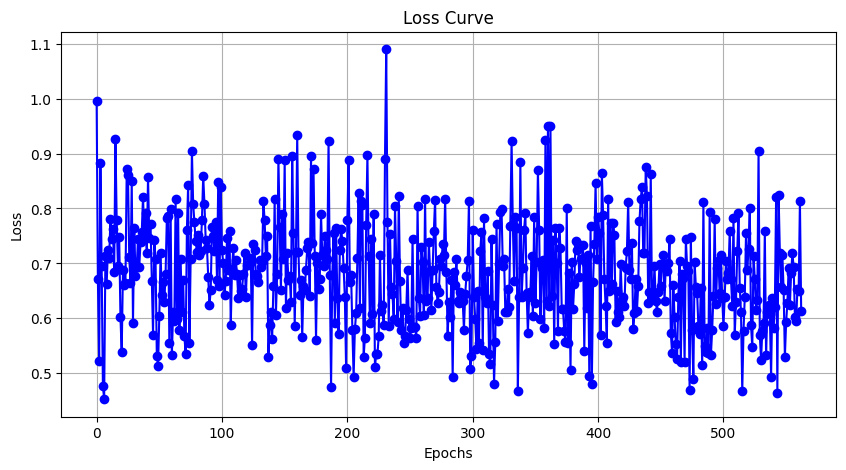

In [ ]:
import matplotlib.pyplot as plt

# 假设这是您的损失值列表
# loss_range = [0.5, 0.4, 0.35, 0.3, 0.25, 0.2, 0.15, 0.1, 0.08, 0.05]

# 创建图形
plt.figure(figsize=(10, 5))
plt.plot(loss_range, marker='o', linestyle='-', color='b')

# 添加标题和标签
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# 显示网格
plt.grid()

# 显示图形
plt.show()